Necessary imports and helper functions for displaying points, boxes, and masks.

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [31]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [32]:
img_name = '0001_1297860395_01_WRI-L1_M014'
image = cv2.imread(f'images/{img_name}.png', cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = cv2.resize(image, (224, 384), interpolation=cv2.INTER_LINEAR)

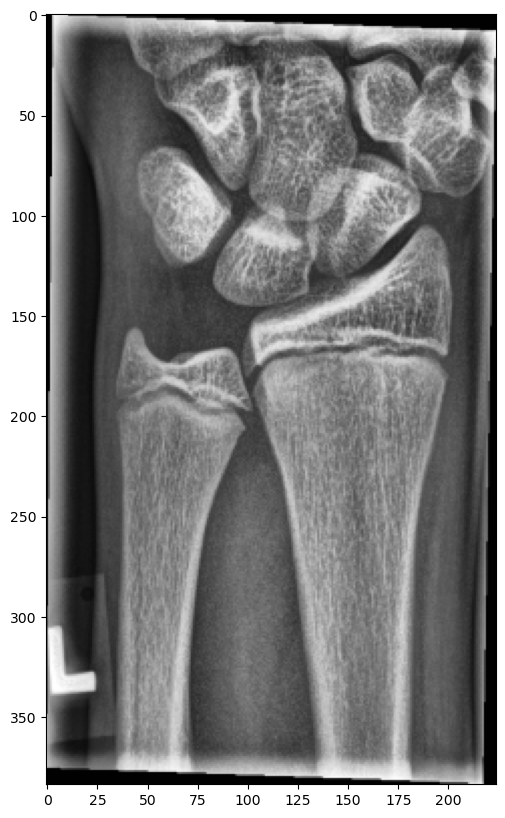

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [34]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"#"cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [35]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [36]:
import h5py
import json

f = h5py.File('/home/ron/Documents/KidsBoneChecker/datasets/data/GRAZPEDWRI-DX/SegGraz_nnunet_predictions.h5', 'r')
lbl_idx_mapping = json.loads(f.attrs['labels'])
ds_seg_masks = f['nnUNet_prediction']
seg_masks = torch.from_numpy(ds_seg_masks[img_name][:])

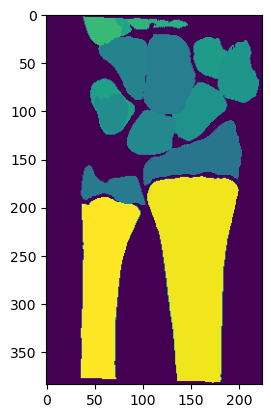

In [37]:
plt.imshow(seg_masks.float().argmax(0))

In [38]:
from segment_anything.utils.prompt_utils import PromptExtractor

prompt_extractor = PromptExtractor(seg_masks)
prompts= prompt_extractor.extract()

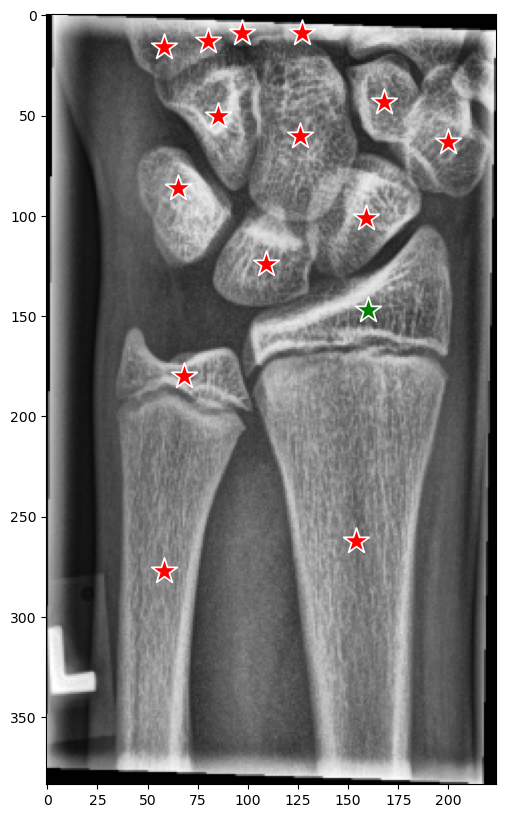

In [39]:
prompt = prompts[0]
input_point = torch.cat([prompt.pos_seeds, prompt.neg_seeds]).numpy()
input_label = np.array([1] * prompt.pos_seeds.shape[0] + [0] * prompt.neg_seeds.shape[0])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [40]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [41]:
masks.shape  # (number_of_masks) x H x W

(3, 384, 224)

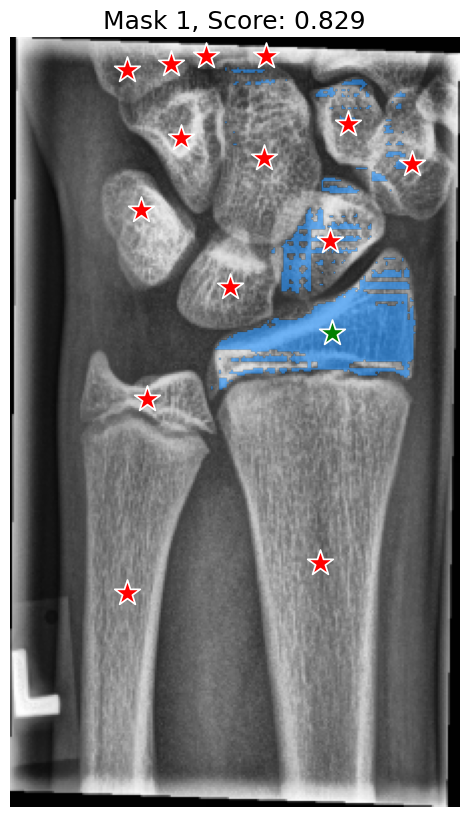

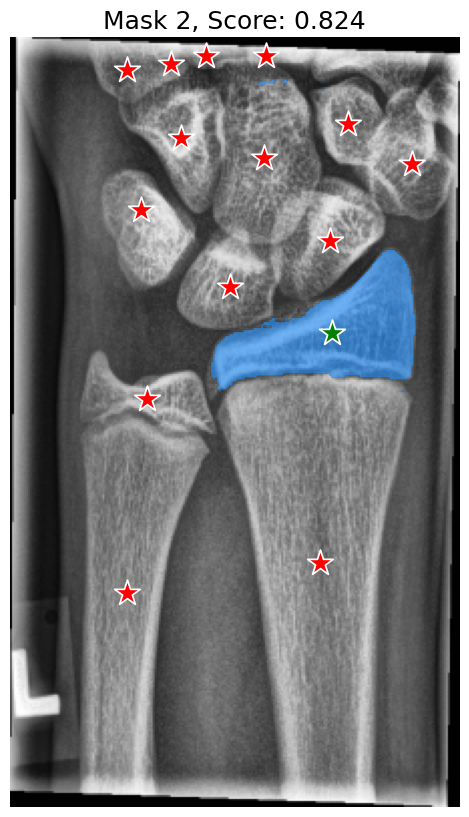

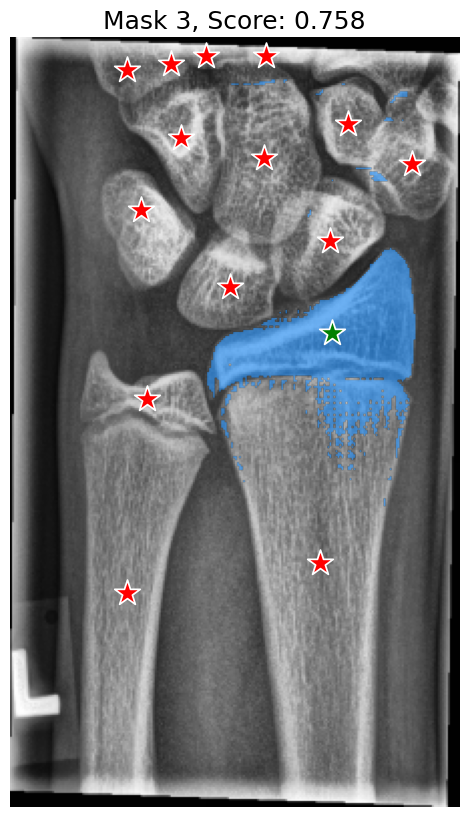

In [42]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [43]:
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

## Try mask refinement without additional prompts

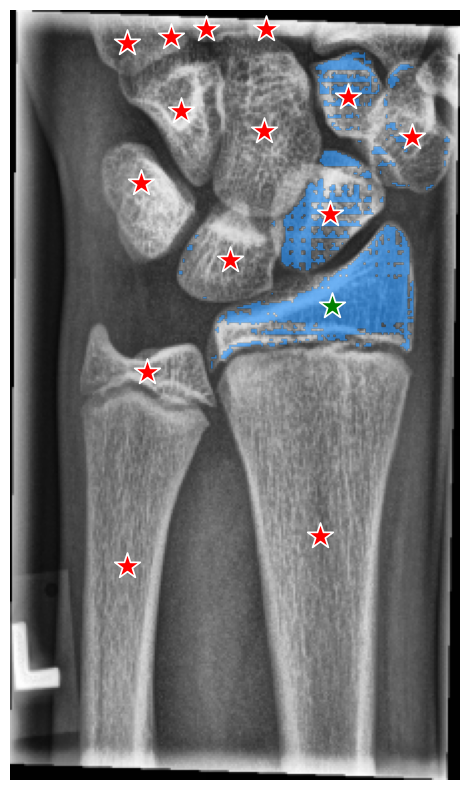

In [44]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Try mask refinement with additional point prompts

In [45]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

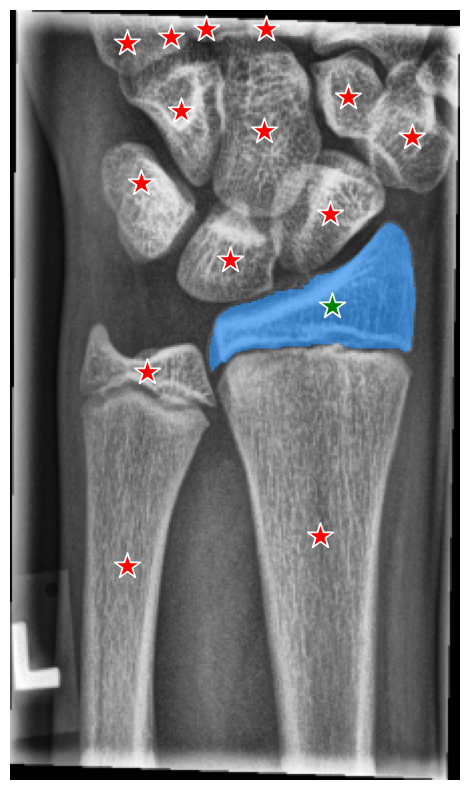

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Try mask refinement with additional box prompt

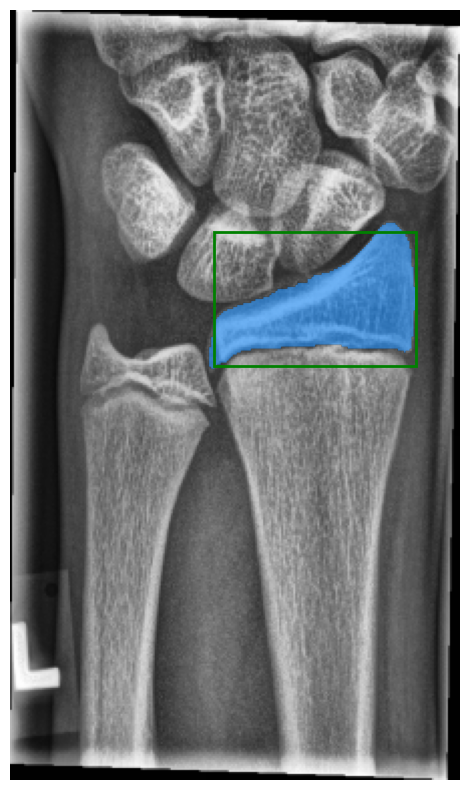

In [47]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=mask_input[None, :, :],
    box=prompt.box.numpy()[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_box(prompt.box.numpy(), plt.gca())
plt.axis('off')
plt.show()

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [48]:
input_box = prompt.box.numpy()

In [49]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

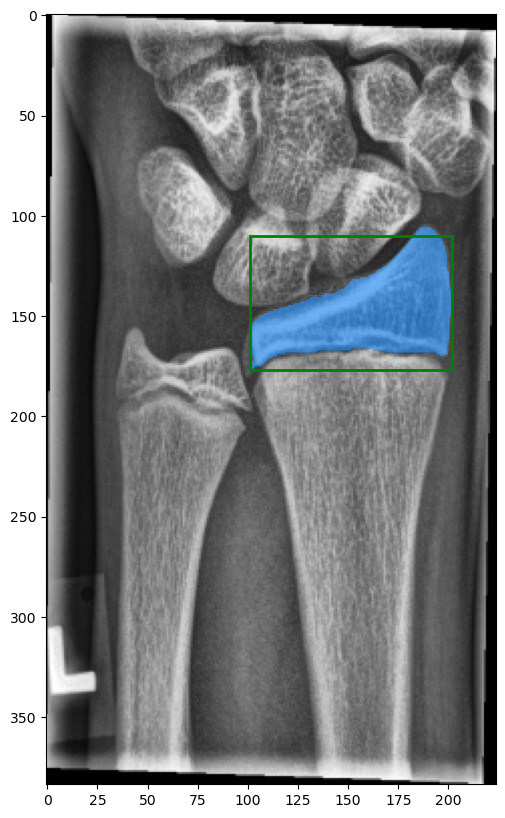

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.show()

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [51]:
masks, _, _ = predictor.predict(
    point_coords=prompt.neg_seeds.numpy(),
    point_labels=np.zeros(prompt.neg_seeds.shape[0]),
    box=input_box,
    multimask_output=False,
)

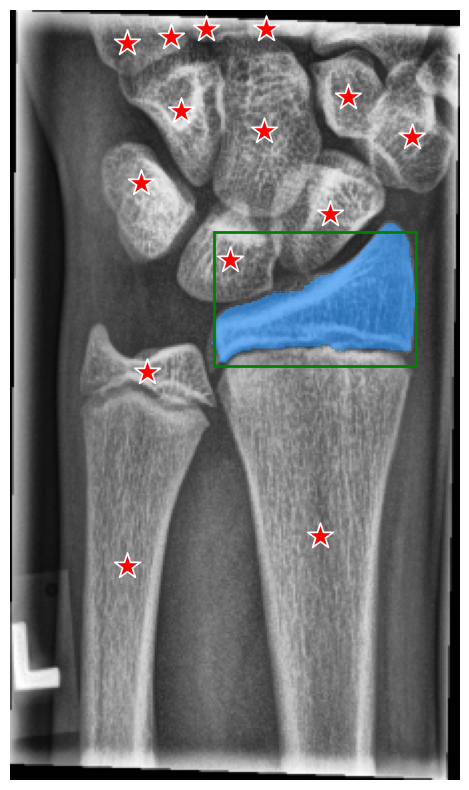

In [52]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(prompt.neg_seeds.numpy(), np.zeros(prompt.neg_seeds.shape[0]), plt.gca())
plt.axis('off')
plt.show()

## Try with mask prompt extracted from nnUNet prediction

In [53]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    mask_input=prompt.mask_logits,
    multimask_output=False,
)

In [54]:
masks.sum()

656

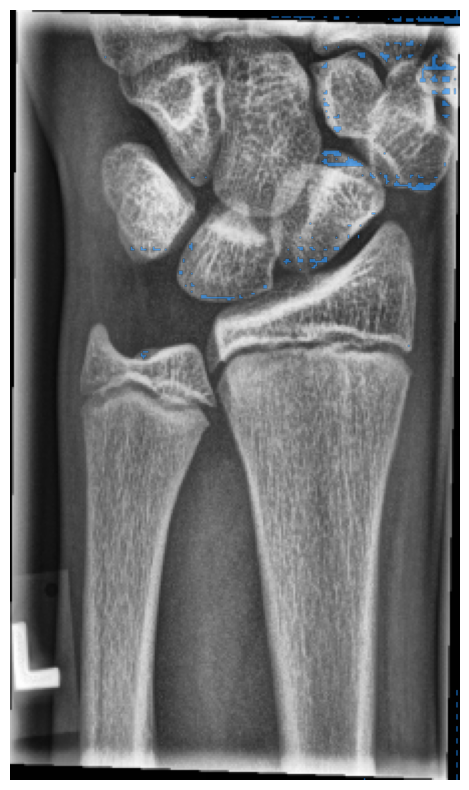

In [55]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
plt.axis('off')
plt.show()